In [49]:
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import math
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import kagglehub

# Download latest version
data_path = kagglehub.dataset_download("manann/quotes-500k")

df = pd.read_csv(data_path + "/quotes.csv")
df.columns = ["quote", "author", "category"]

In [21]:
# most authors have a "," and then where the quote is from.
# So splitting with "," and keeping only the first part seems like the right choice.
df["author"] = df["author"]\
    .astype(str).str.split(",").\
    str[0].apply(lambda x: re.sub(f"[{string.punctuation}“‘\d…]", "", x)).\
    str.strip().str.lower()

# dropping all empty data
df = df.dropna(subset=["author", "quote"])

def preprocess_quote(text):
    # Convert the input to string to handle potential float values
    text = str(text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}“‘\d…]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) >= 4]
    return tokens

df["processed_quote"] = df["quote"].apply(preprocess_quote)

In [22]:
# Group quotes by author
author_texts = df.groupby("author")["processed_quote"].sum().to_dict()

def print_frequencies(author_texts, author):
    word_count = Counter(author_texts[author])
    print(f"author: {author}, top 2: {word_count.most_common(2)}")

print_frequencies(author_texts, "paulo coelho")
print_frequencies(author_texts, "fyodor dostoevsky")
print_frequencies(author_texts, "stephen king")

author: paulo coelho, top 2: [('love', 171), ('life', 145)]
author: fyodor dostoevsky, top 2: [('happiness', 4), ('live', 2)]
author: stephen king, top 2: [('like', 154), ('time', 92)]


In [23]:
preprocessed_docs = []
for author in ["paulo coelho", "fyodor dostoevsky", "stephen king"]:
    preprocessed_docs.append(author_texts[author])

# Compute TF
def compute_tf(document):
    tf_doc = Counter(document)
    len_doc = len(document)
    return {word: count / len_doc for word, count in tf_doc.items()}

# Compute IDF
def compute_idf(doc_list):
    N = len(doc_list)
    idf_dict = dict.fromkeys(set(word for doc in doc_list for word in doc), 0)
    for doc in doc_list:
        for word in set(doc):
            idf_dict[word] += 1
    return {word: math.log((N + 1) / (val + 1)) + 1 for word, val in idf_dict.items()}

tf_per_doc = [compute_tf(doc) for doc in preprocessed_docs]
idfs = compute_idf(preprocessed_docs)

# Compute TF-IDF and Apply L2 Normalization
def compute_tfidf_and_normalize(tf, idfs):
    tfidf = {word: (tf[word] * idfs[word]) for word in tf}
    norm = math.sqrt(sum(val**2 for val in tfidf.values()))
    return {word: val / norm for word, val in tfidf.items()}

tfidf_normalized = [compute_tfidf_and_normalize(doc, idfs) for doc in tf_per_doc]

# Creating DataFrame to store TF-IDF vectors
df_tfidf = pd.DataFrame(tfidf_normalized).fillna(0)

# Sorting DataFrame columns alphabetically
df_tfidf_sorted = df_tfidf.sort_index(axis=1)

# Printing the sorted DataFrame
print("TF-IDF Vectors stored in DataFrame, sorted alphabetically by words:")
df_tfidf_sorted.head()


TF-IDF Vectors stored in DataFrame, sorted alphabetically by words:


,abandon,abandoned,abandonment,abandons,abilities,ability,able,aboutandy,abroad,absence,...,بالإيمان,ترانا,قُدُماً,لأحدنا,لأننا,نتحلّى,نمتلك,نمضي,ولأننا,يتنبّأ
0,0.00617,0.003085,0.003085,0.009255,0.003085,0.011732,0.074707,0.000000,0.00617,0.007039,...,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074500,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.014252,0.009223,0.003123,0.00000,0.004751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
preprocessed_corpus = []
for author in author_texts:
    preprocessed_corpus.append(author_texts[author])

word2vec_model = Word2Vec(preprocessed_corpus, vector_size=150, window=7, min_count=10, workers=4)

In [34]:
preprocessed_corpus = []
for author in author_texts:
    preprocessed_corpus.append(author_texts[author])

word2vec_model2 = Word2Vec(preprocessed_corpus, vector_size=50, window=3, min_count=3, workers=4)

In [39]:
# comparing both models

print("with model [Context window size: 7, Vector dimensions: 150, Negative samples: 10]: ")
print(word2vec_model.wv.most_similar(positive=["imagination"]))
print(word2vec_model.wv.similarity("fear", "knowledge"))

print("with model [Context window size: 3, Vector dimensions: 50, Negative samples: 3]: ")
print(word2vec_model2.wv.most_similar(positive=["imagination"]))
print(word2vec_model2.wv.similarity("fear", "knowledge"))

with model [Context window size: 7, Vector dimensions: 150, Negative samples: 10]: 
[('figment', 0.6873266696929932), ('imaginations', 0.6786295771598816), ('imaginative', 0.6376766562461853), ('creativity', 0.6280215978622437), ('fantasy', 0.5807527303695679), ('creative', 0.5631846189498901), ('figments', 0.5534444451332092), ('marvelous', 0.5369451642036438), ('vivid', 0.535451352596283), ('fantastic', 0.5290734767913818)]
0.11761811
with model [Context window size: 3, Vector dimensions: 50, Negative samples: 3]: 
[('imaginations', 0.7525529861450195), ('creativity', 0.7469682097434998), ('figment', 0.7055875062942505), ('creative', 0.6948665976524353), ('overactive', 0.6909324526786804), ('imaginative', 0.6865249872207642), ('figments', 0.6846135854721069), ('minds', 0.6646610498428345), ('curiosity', 0.6476185917854309), ('fantasy', 0.614404022693634)]
0.33852094


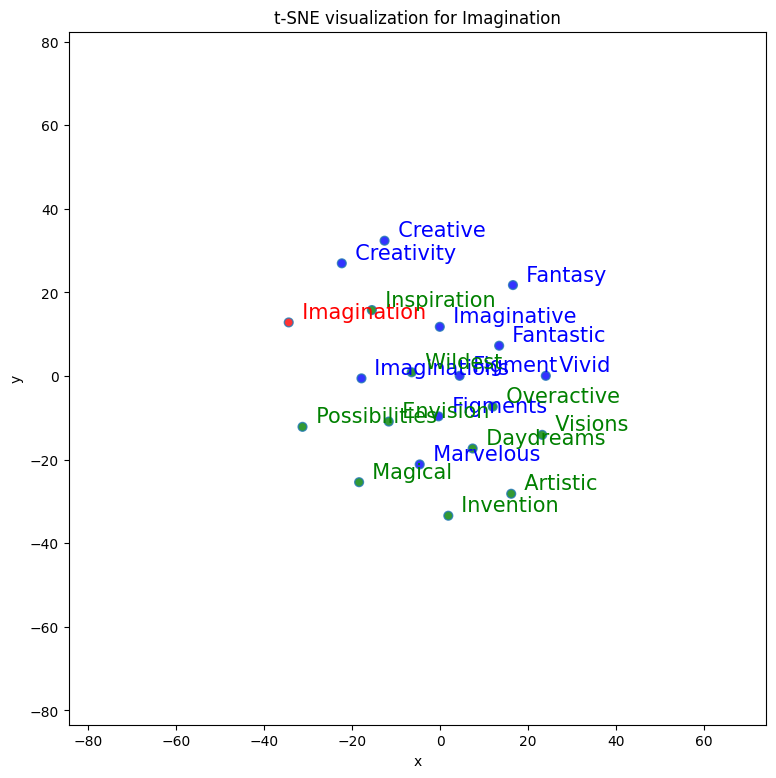

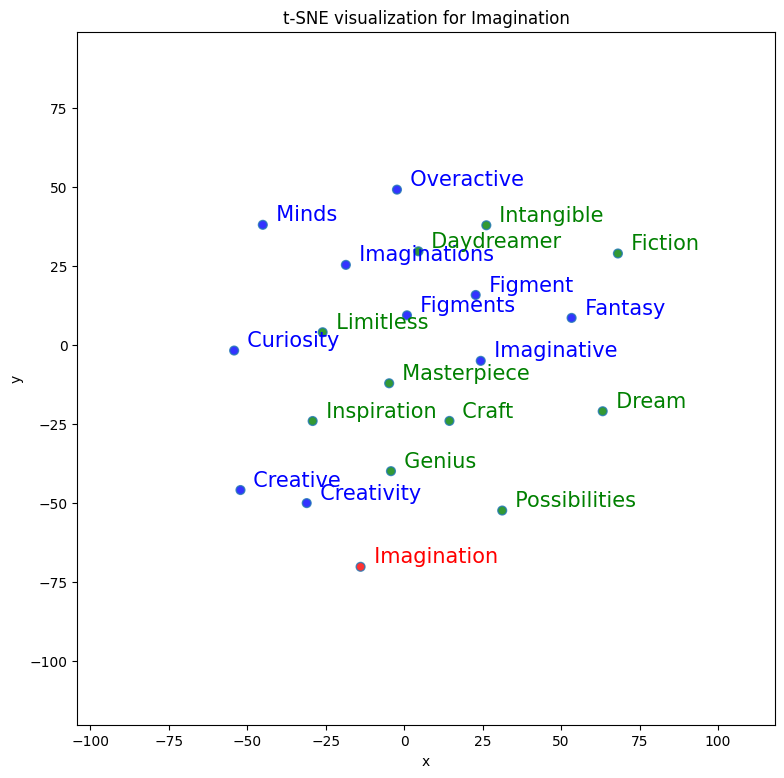

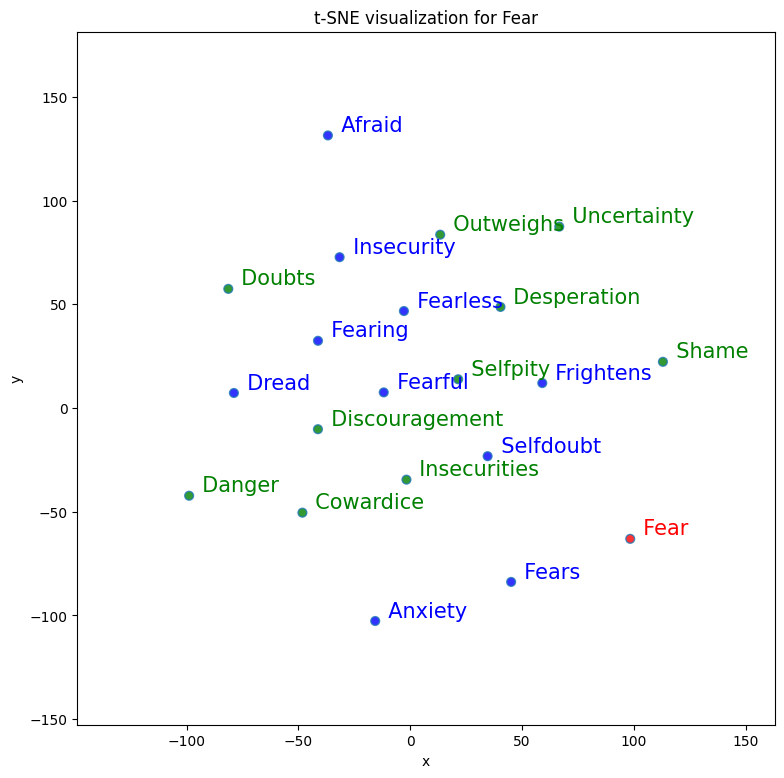

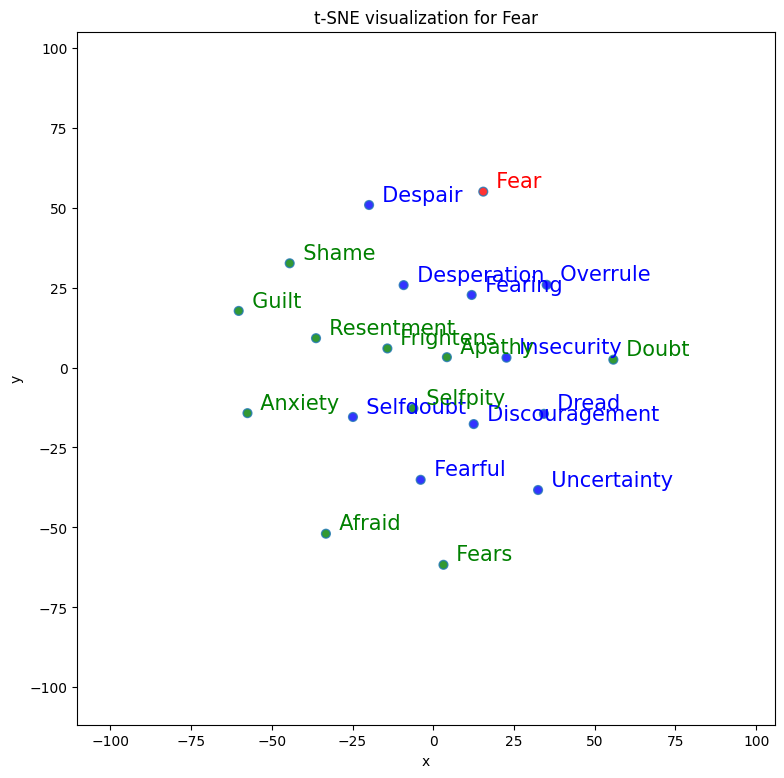

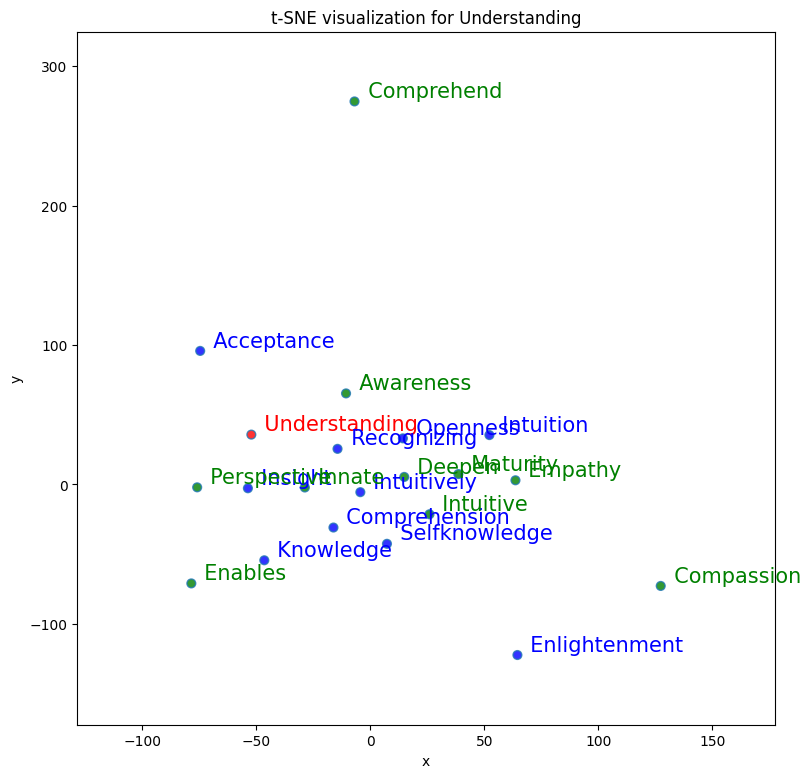

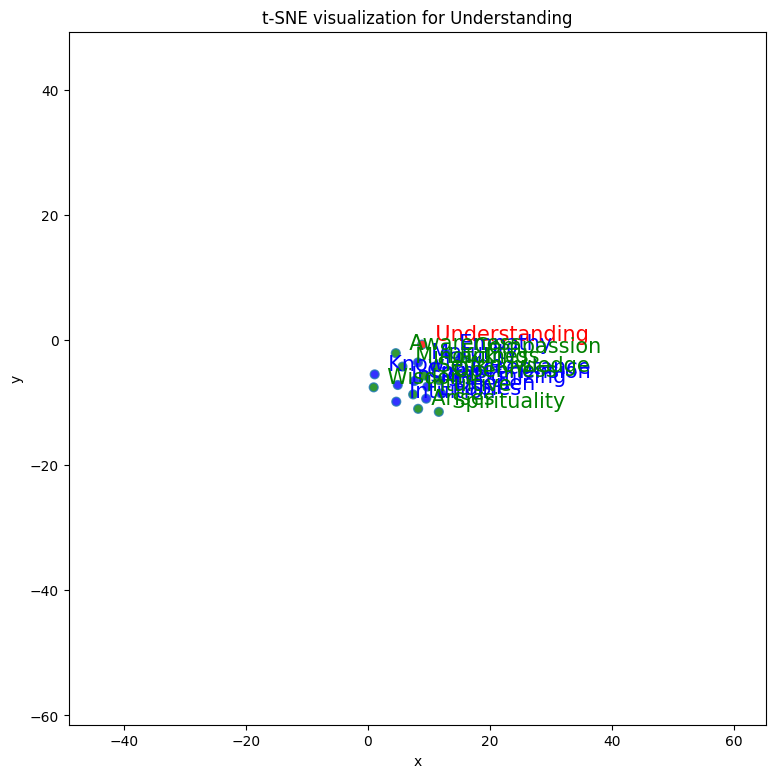

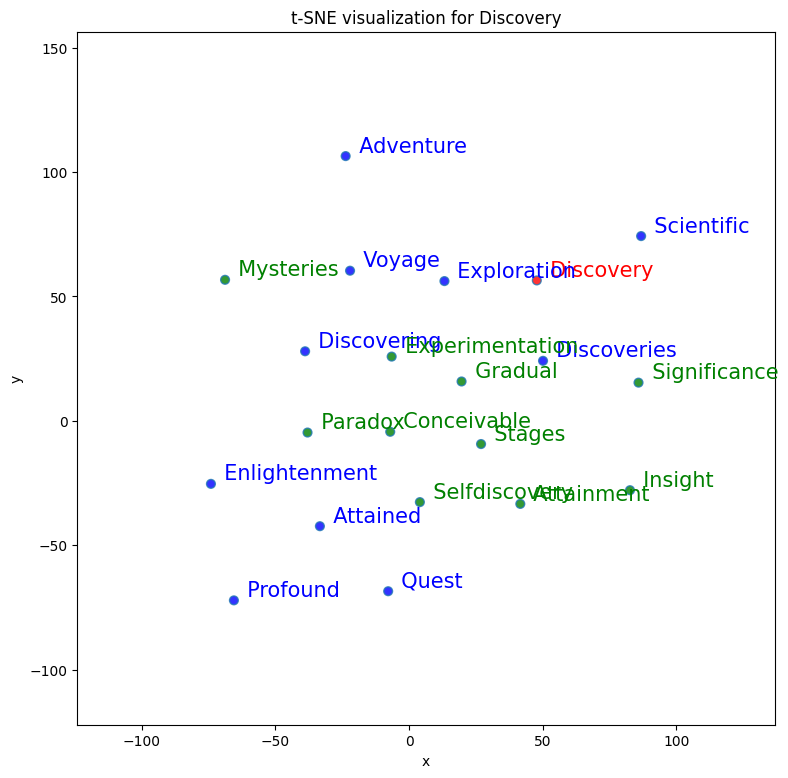

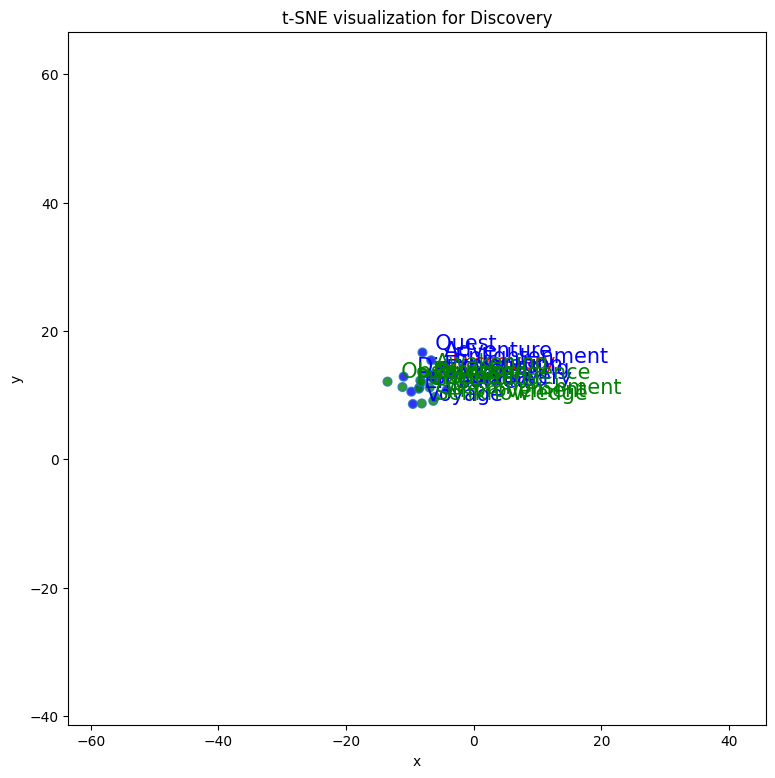

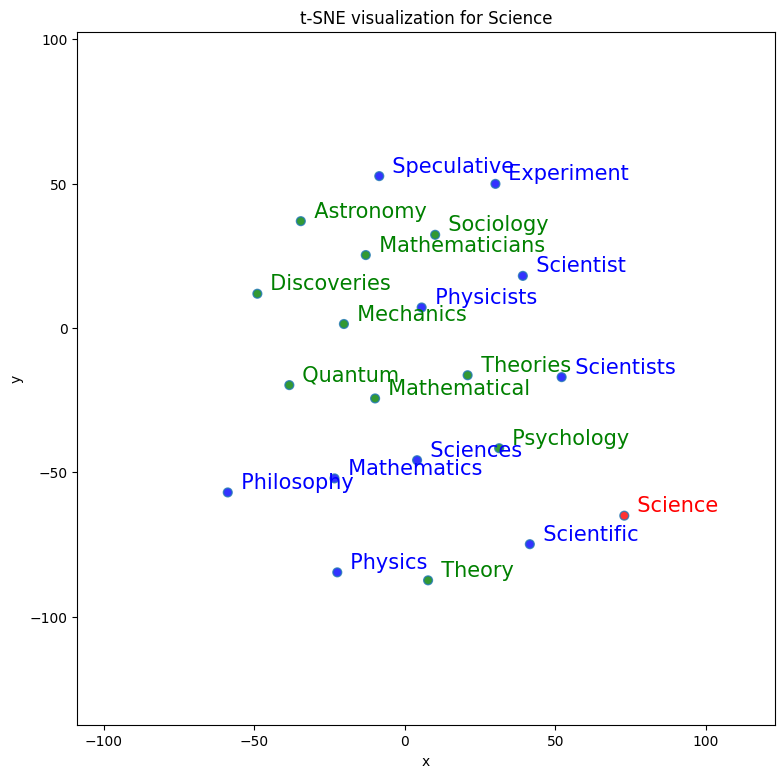

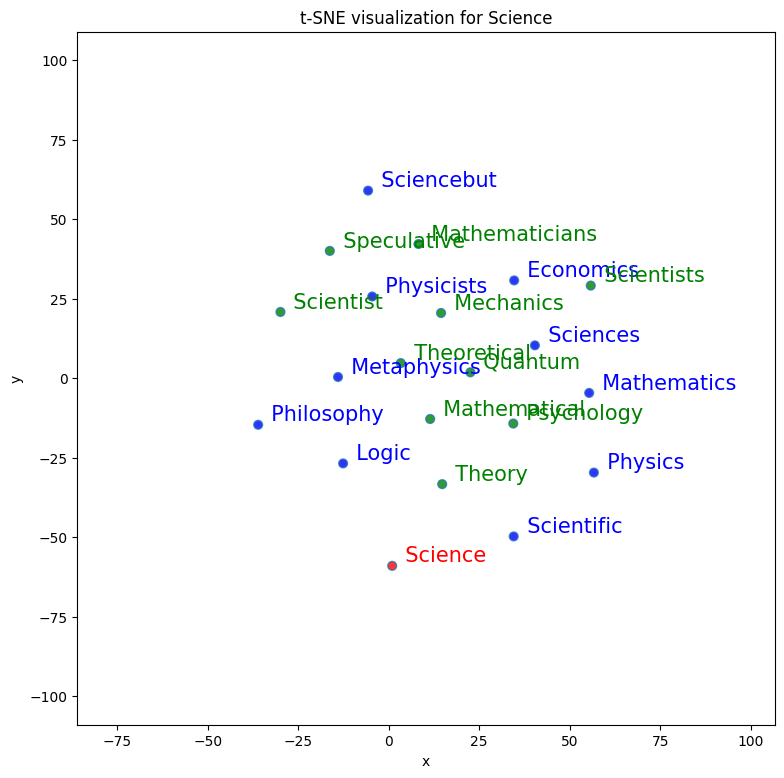

In [51]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    # Change the size to match the vector size of the model
    arrays = np.empty((0, model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

for word in ["imagination", "fear", "understanding", "discovery", "science"]:
    tsnescatterplot(word2vec_model, word, [t[0] for t in word2vec_model.wv.most_similar(positive=[word], topn=20)][10:])
    tsnescatterplot(word2vec_model2, word, [t[0] for t in word2vec_model2.wv.most_similar(positive=[word], topn=20)][10:])

In [52]:
def analyze_embeddings(model1, model2, target_words):
    """Analyze and compare embeddings from different Word2Vec configurations"""

    def get_pairwise_similarities(model, words):
        """Calculate pairwise similarities between words"""
        similarities = {}
        for i, word1 in enumerate(words):
            for word2 in words[i+1:]:
                pair = f"{word1}-{word2}"
                similarities[pair] = model.wv.similarity(word1, word2)
        return similarities

    def compare_configurations(sim1, sim2):
        """Compare similarities between configurations"""
        differences = {}
        for pair in sim1.keys():
            diff = abs(sim1[pair] - sim2[pair])
            differences[pair] = diff
        return differences

    # Get similarities for both configurations
    print("\nEmbedding Analysis:")
    print("\n1. Pairwise Similarities:")

    sim_config1 = get_pairwise_similarities(model1, target_words)
    sim_config2 = get_pairwise_similarities(model2, target_words)

    print("\nConfiguration 1 (window=3, dim=50):")
    for pair, sim in sim_config1.items():
        print(f"{pair}: {sim:.4f}")

    print("\nConfiguration 2 (window=7, dim=150):")
    for pair, sim in sim_config2.items():
        print(f"{pair}: {sim:.4f}")

    # Compare configurations
    differences = compare_configurations(sim_config1, sim_config2)
    print("\n2. Impact of Configuration Changes:")
    print("Absolute differences between configurations:")
    for pair, diff in differences.items():
        print(f"{pair}: {diff:.4f}")

    # Analyze context impact
    print("\n3. Context Window Impact Analysis:")
    for word in target_words:
        print(f"\nNearest neighbors for '{word}':")
        print("Config 1 (small window):", model1.wv.most_similar(word)[:3])
        print("Config 2 (large window):", model2.wv.most_similar(word)[:3])

    # Analyze dimensionality impact
    print("\n4. Dimensionality Impact Analysis:")
    for word in target_words:
        vec1 = model1.wv[word]
        vec2 = model2.wv[word]
        print(f"\nVector statistics for '{word}':")
        print(f"Config 1 - Mean: {vec1.mean():.4f}, Std: {vec1.std():.4f}")
        print(f"Config 2 - Mean: {vec2.mean():.4f}, Std: {vec2.std():.4f}")

analyze_embeddings(word2vec_model, word2vec_model2, ["imagination", "fear", "understanding", "discovery", "science"])


Embedding Analysis:

1. Pairwise Similarities:

Configuration 1 (window=3, dim=50):
imagination-fear: 0.1870
imagination-understanding: 0.1974
imagination-discovery: 0.3041
imagination-science: 0.2353
fear-understanding: 0.0880
fear-discovery: 0.0779
fear-science: -0.0559
understanding-discovery: 0.3827
understanding-science: 0.3384
discovery-science: 0.5161

Configuration 2 (window=7, dim=150):
imagination-fear: 0.3869
imagination-understanding: 0.2975
imagination-discovery: 0.4186
imagination-science: 0.3730
fear-understanding: 0.2858
fear-discovery: 0.2619
fear-science: 0.0829
understanding-discovery: 0.4929
understanding-science: 0.4950
discovery-science: 0.5211

2. Impact of Configuration Changes:
Absolute differences between configurations:
imagination-fear: 0.2000
imagination-understanding: 0.1001
imagination-discovery: 0.1145
imagination-science: 0.1377
fear-understanding: 0.1978
fear-discovery: 0.1841
fear-science: 0.1387
understanding-discovery: 0.1103
understanding-science: